In [1]:
import argparse
import os
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from captum.attr import GradientShap, IntegratedGradients, Saliency
from torch.utils.data import DataLoader, RandomSampler, Subset, random_split

from lfxai.explanations.examples import (
    InfluenceFunctions,
    TracIn,
)
from lfxai.explanations.features import attribute_auxiliary
from lfxai.models.time_series import RecurrentAutoencoder
from lfxai.utils.datasets import ECG5000
from lfxai.utils.feature_attribution import generate_tseries_masks
from lfxai.utils.metrics import similarity_rates

c:\Users\albac\anaconda3\envs\minitaskVDSLab\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Parameters
random_seed: int = 1
batch_size: int = 50
dim_latent: int = 16
n_epochs: int = 150
subtrain_size: int = 200
subtest_size: int = 200
checkpoint_interval: int = 10

torch.random.manual_seed(random_seed)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
data_dir = Path.cwd() / "data/ecg5000"
save_dir = Path.cwd() / "results/ecg5000/consistency_examples"
if not save_dir.exists():
    os.makedirs(save_dir)

In [3]:
# Load dataset
train_dataset = ECG5000(data_dir, experiment="examples")
train_dataset, test_dataset = random_split(train_dataset, (4000, 1000))
train_loader = DataLoader(train_dataset, batch_size, True)
test_loader = DataLoader(test_dataset, batch_size, False)
time_steps = 140
n_features = 1

c:\Users\albac\anaconda3\envs\minitaskVDSLab\lib\site-packages\lfxai\utils\datasets.py:284: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_df = total_df.append(pd.DataFrame(data))


In [4]:
# Train the denoising autoencoder
autoencoder = RecurrentAutoencoder(time_steps, n_features, dim_latent)
save_dir = Path.cwd() / "results/ecg5000/consistency_examples"
if not save_dir.exists():
    os.makedirs(save_dir)

if not (save_dir / (autoencoder.name + ".pt")).exists():
    autoencoder.fit(
        device,
        train_loader,
        test_loader,
        save_dir,
        n_epochs,
        checkpoint_interval=checkpoint_interval,
    )
else:
    autoencoder.load_state_dict(
        torch.load(save_dir / (autoencoder.name + ".pt")), strict=False
    )
autoencoder.train().to(device)

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 32, batch_first=True)
    (rnn2): LSTM(32, 16, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(16, 16, batch_first=True)
    (rnn2): LSTM(16, 32, batch_first=True)
    (output_layer): Linear(in_features=32, out_features=1, bias=True)
  )
  (loss_f): L1Loss()
)

In [102]:
# Prepare subset loaders for example-based explanation methods
y_train = torch.tensor([train_dataset[k][1] for k in range(len(train_dataset))])
# idx_subtrain = [
#     torch.nonzero(y_train == (n % 2))[n // 2].item() for n in range(subtrain_size)
# ]
# idx_subtest = torch.randperm(len(test_dataset))[:subtest_size]
idx_subtrain_200 = torch.load(save_dir / "results_idx_subtrain200.pt")
idx_subtrain_500 = torch.load(save_dir / "results_idx_subtrain500.pt")
idx_subtrain_1000 = torch.load(save_dir / "results_idx_subtrain1000.pt")
idx_subtest = torch.load(save_dir / "results_idx_subtest200.pt")
train_subset = Subset(train_dataset, idx_subtrain_200)
test_subset = Subset(test_dataset, idx_subtest)
subtrain_loader = DataLoader(train_subset)
subtest_loader = DataLoader(test_subset)
labels_subtrain = torch.cat([label for _, label in subtrain_loader])
labels_subtest = torch.cat([label for _, label in subtest_loader])
recursion_depth = 100
train_sampler = RandomSampler(
    train_dataset, replacement=True, num_samples=recursion_depth * batch_size
)
train_loader_replacement = DataLoader(
    train_dataset, batch_size, sampler=train_sampler
)

In [15]:
print(idx_subtest)

tensor([374, 677,  12,  14, 187, 308, 797, 265,  64,  52, 524, 985, 834, 174,
        969, 726, 775, 754, 589, 176, 914, 895, 991, 913,   7, 200,  56, 785,
        954, 397,  83,  41,  89, 394, 478, 305, 253, 134, 982, 894, 849, 401,
        828, 326, 331, 281, 455, 687, 104, 563, 918, 421, 928, 474, 738, 126,
        758,  58,  73, 927, 447,  87, 577,  24, 437,  90, 246, 135, 491, 169,
        823, 565,  11, 493, 352, 230, 712, 692, 902, 217, 362, 286, 771, 499,
        602, 130, 903,  28, 469,  68, 623, 423,  93, 322, 383, 528, 225, 627,
        212, 353, 987, 622, 537, 216, 611, 235, 947, 645, 438,  43, 629, 494,
        942, 878, 599, 205, 871, 832, 841, 946, 348, 603, 693, 392, 772, 732,
        313, 196, 213, 561, 975, 674, 139, 900, 280, 214, 497, 190, 695, 381,
        272, 427, 471, 698, 938, 479, 777, 159,  55, 231, 194, 909, 452, 262,
          4, 989, 284, 323, 539, 896, 737,  76, 457, 590, 407, 466, 224, 860,
        830, 757,  86, 527, 207, 333, 868, 935, 709, 974, 127, 2

In [16]:
# Fitting explainers, computing the metric and saving everything (not execute now)
l1_loss = torch.nn.L1Loss()
explainer_list = [
    # InfluenceFunctions(autoencoder, l1_loss, save_dir / "if_grads"),
    TracIn(autoencoder, l1_loss, save_dir / "tracin_grads"),
]
results_list = []
# n_top_list = [1, 2, 5, 10, 20, 30, 40, 50, 100]
frac_list = [0.05, 0.1, 0.2, 0.5, 0.7, 1.0]
n_top_list = [int(frac * len(idx_subtrain_200)) for frac in frac_list]

In [ ]:
results_dict = {}
for explainer in explainer_list:
    if isinstance(explainer, InfluenceFunctions):
        with torch.backends.cudnn.flags(enabled=False):
            attribution = explainer.attribute_loader(
                device,
                subtrain_loader,
                subtest_loader,
                train_loader_replacement=train_loader_replacement,
                recursion_depth=recursion_depth,
            )
    else:
        attribution = explainer.attribute_loader(
            device, subtrain_loader, subtest_loader
        )
    autoencoder.load_state_dict(
        torch.load(save_dir / (autoencoder.name + ".pt")), strict=False
    )
    results_dict[str(explainer)] = attribution

In [93]:
# Open results dictionary
save_dir = Path.cwd() / "results/ecg5000/consistency_examples"

with open(save_dir / "results_dict_sub200.pkl", "rb") as f:
    results_dict_200 = pickle.load(f)

with open(save_dir / "results_dict_sub500.pkl", "rb") as f:
    results_dict_500 = pickle.load(f)

with open(save_dir / "results_dict_sub1000.pkl", "rb") as f:
    results_dict_1000 = pickle.load(f)

In [18]:
results_dict['TracIn'].shape   

results_list = []

for explainer in results_dict.keys():
    attribution = results_dict[explainer]
    sim_most, sim_least = similarity_rates(
        attribution, labels_subtrain, labels_subtest, n_top_list
    )
    results_list += [
        [str(explainer), "Most Important", 100 * frac, sim]
        for frac, sim in zip(frac_list, sim_most)
    ]
    results_list += [
        [str(explainer), "Least Important", 100 * frac, sim]
        for frac, sim in zip(frac_list, sim_least)
    ]
results_df = pd.DataFrame(
    results_list,
    columns=[
        "Explainer",
        "Type of Examples",
        "% Examples Selected",
        "Similarity Rate",
    ],
)

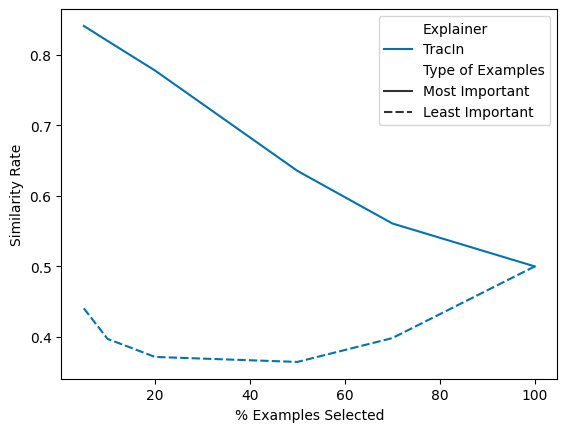

In [19]:
results_df.to_csv(save_dir / "metrics.csv")
sns.lineplot(
    data=results_df,
    x="% Examples Selected",
    y="Similarity Rate",
    hue="Explainer",
    style="Type of Examples",
    palette="colorblind",
)
plt.savefig(save_dir / "ecg5000_similarity_rates.pdf")

# NEW: removing oponents

In [75]:
oponents_index_200 = (results_dict_200['TracIn'].mean(axis=0) < 0).nonzero().flatten()
oponents_index_200

tensor([ 11,  83,  92, 134, 155])

In [76]:
results_dict_200['TracIn'].mean(axis=0)[oponents_index_200]

tensor([-0.9262, -3.0480, -0.0120, -6.4335, -2.0220])

In [77]:
for i in range(5):
    print(idx_subtrain_200[oponents_index_200[i]])

23
117
70
103
199


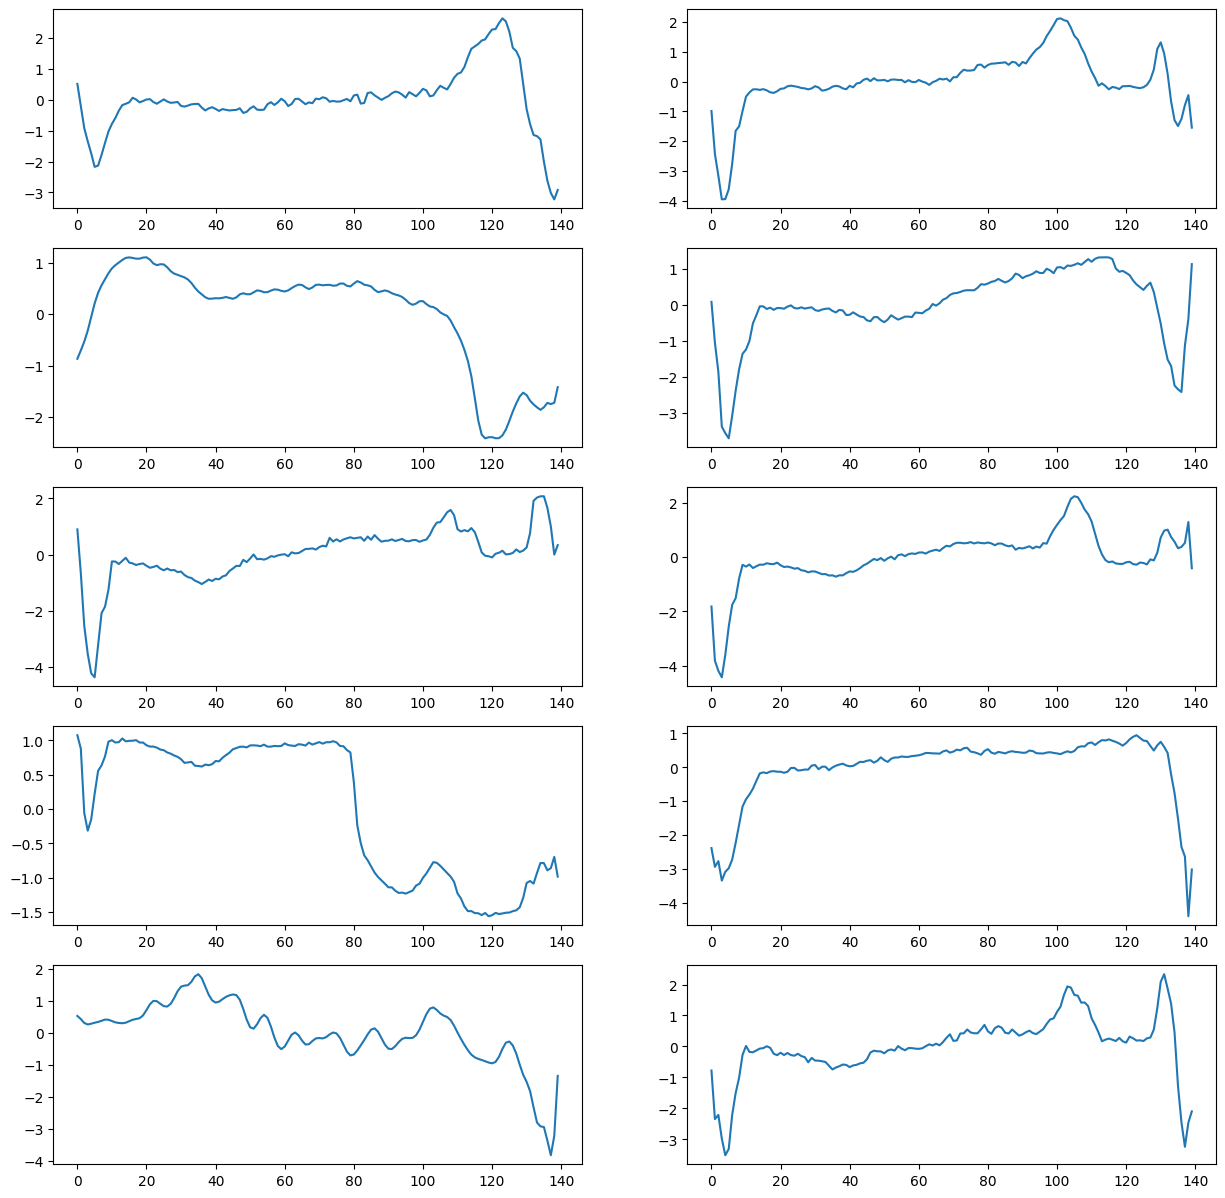

In [91]:
# plot in subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 15))

for i in range(5):
    # plot oponents
    axes[i, 0].plot(train_dataset[idx_subtrain_200[oponents_index_200[i]]][0].numpy())
    # plot random
    axes[i, 1].plot(train_dataset[idx_subtrain_200[50 + i]][0].numpy())

In [81]:
oponents_index_500 = (results_dict_500['TracIn'].sum(axis=0) < 0).nonzero().flatten()
oponents_index_500

tensor([ 83,  92, 134, 155, 245, 326, 412, 446, 461, 475])

In [61]:
results_dict_500['TracIn'].mean(axis=0)[oponents_index_500]

tensor([-2.3498, -0.6209, -2.3617, -2.8699, -0.8349, -6.5848, -1.0552, -0.1927,
        -6.6874, -0.0558])

In [69]:
for i in range(10):
    print(idx_subtrain_500[oponents_index_500[i]])

117
70
103
199
288
284
346
368
591
605


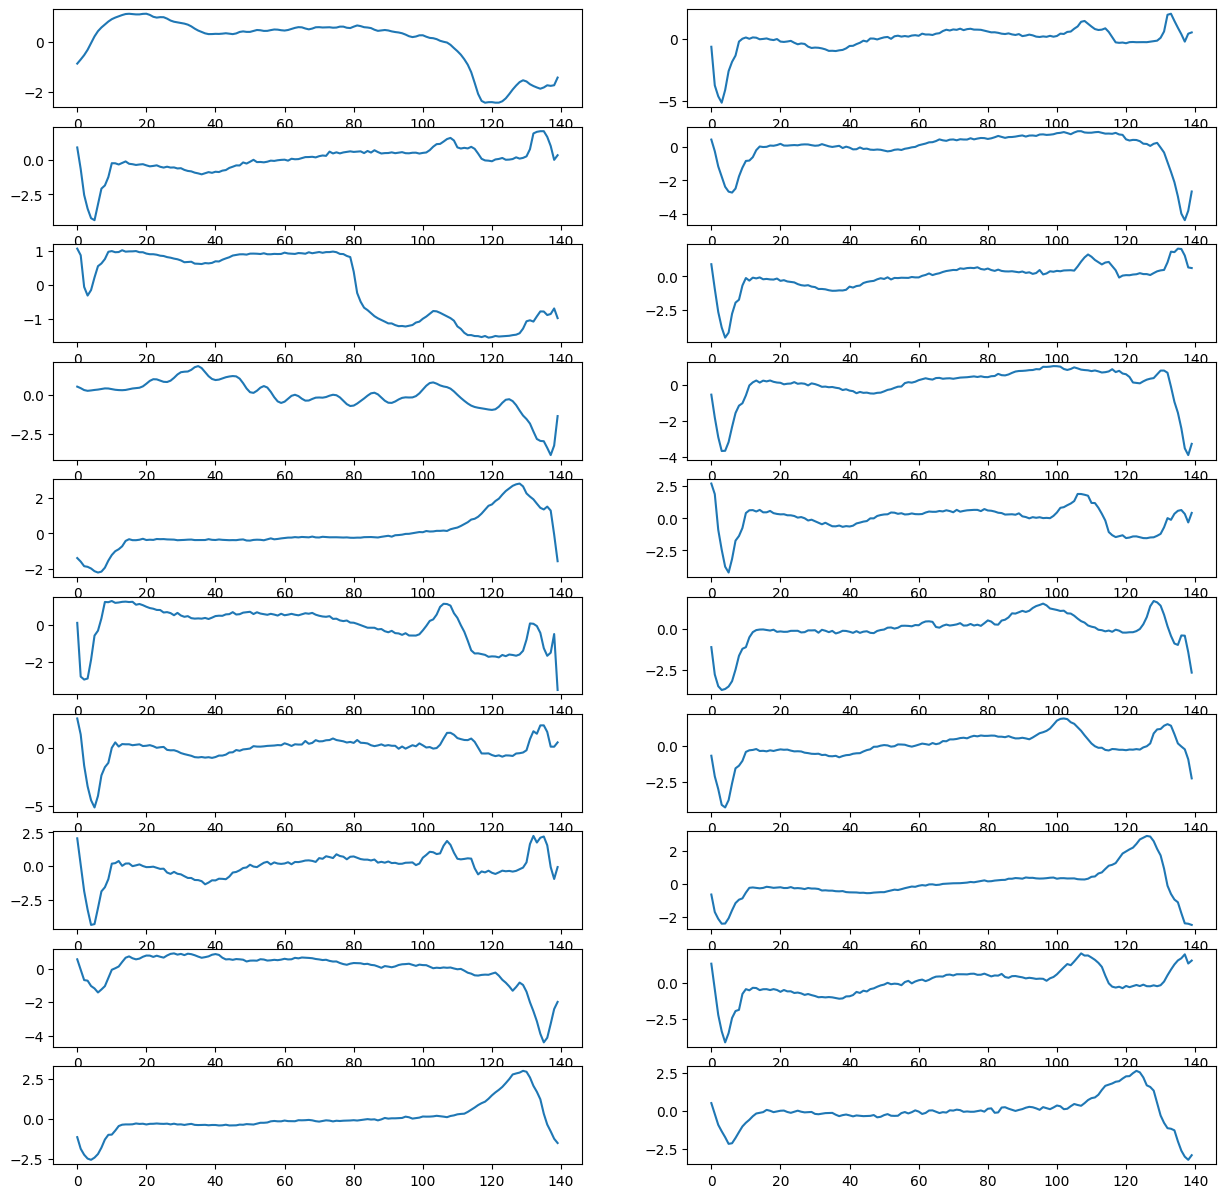

In [103]:
# plot in subplots
fig, axes = plt.subplots(10, 2, figsize=(15, 15))

for i in range(10):
    # plot oponents
    axes[i, 0].plot(train_dataset[idx_subtrain_500[oponents_index_500[i]]][0].numpy())
    # plot random samples
    axes[i, 1].plot(train_dataset[idx_subtrain_500[i+2]][0].numpy())

In [97]:
oponents_index_1000 = (results_dict_1000['TracIn'].mean(axis=0) < 0).nonzero().flatten()
oponents_index_1000.shape

torch.Size([40])

In [98]:
results_dict_1000['TracIn'].mean(axis=0)[oponents_index_1000]

tensor([-2.5506, -1.4861, -3.7597, -3.9325, -0.3272, -0.0224, -0.5272, -1.0711,
        -2.4408, -7.3595, -1.1011, -2.3119, -3.2615, -4.4616, -0.1150, -0.3759,
        -3.5818, -0.9091, -0.0859, -1.3476, -1.1058, -0.0843, -0.6300, -1.4038,
        -2.3907, -0.2440, -1.3152, -0.3535, -1.4064, -2.4954, -3.6624, -1.3687,
        -1.3171, -0.2708, -1.0708, -1.0948, -4.3742, -3.7553, -0.8842, -0.4055])

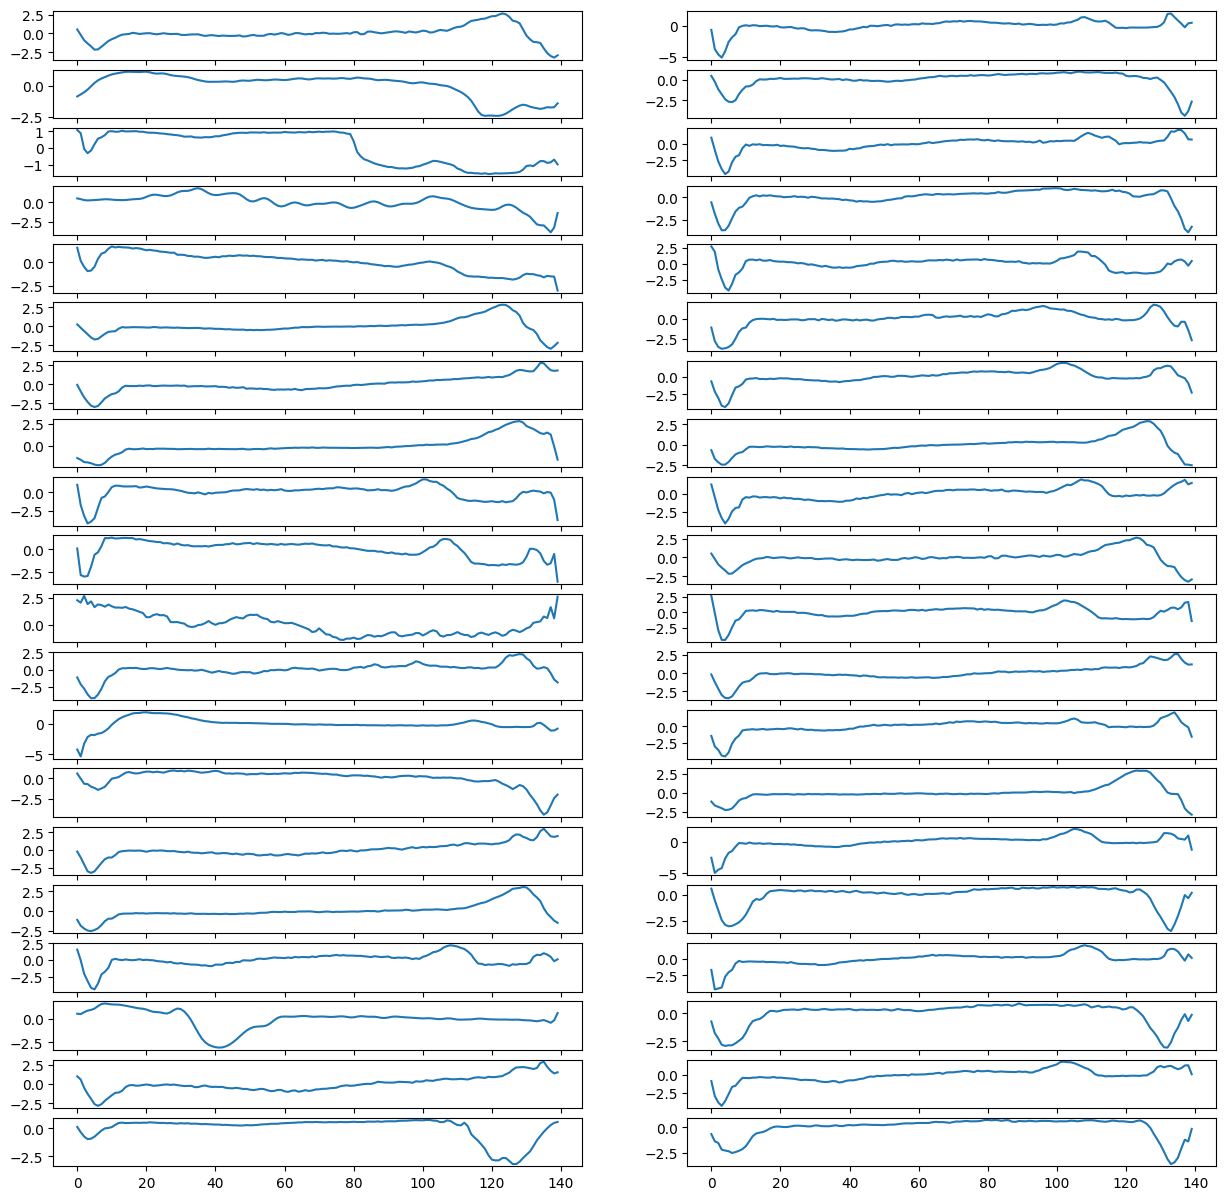

In [107]:
# plot in subplots
fig, axes = plt.subplots(20, 2, figsize=(15, 15))

for i in range(20):
    # plot oponents
    axes[i, 0].plot(train_dataset[idx_subtrain_1000[oponents_index_1000[i]]][0].numpy())
    # plot random samples
    axes[i, 1].plot(train_dataset[idx_subtrain_1000[i+2]][0].numpy())

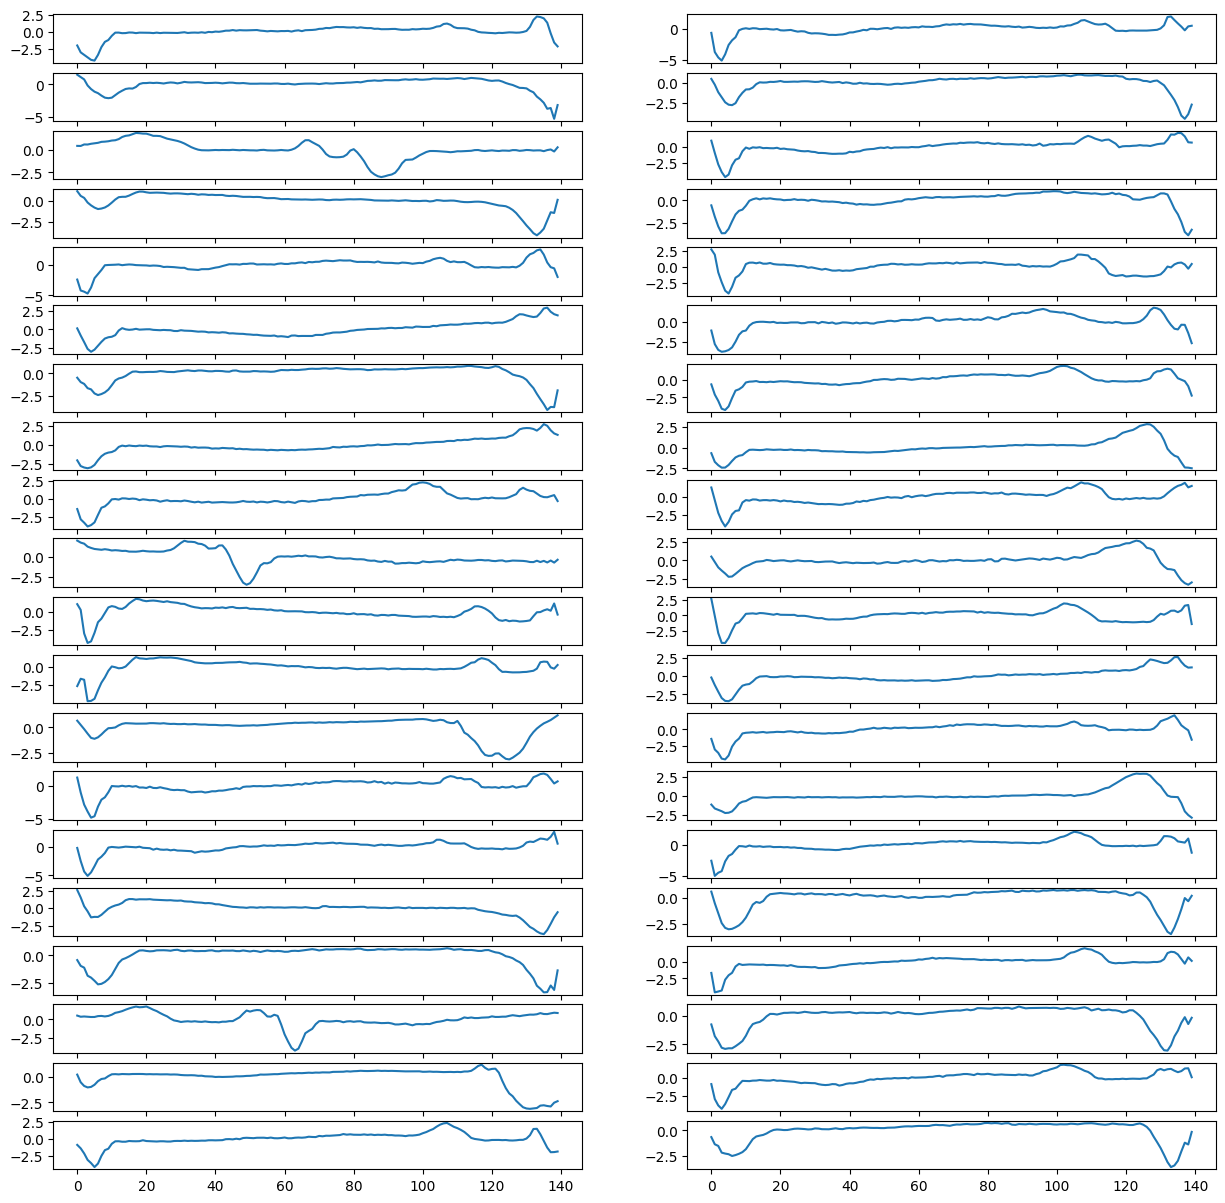

In [109]:
fig, axes = plt.subplots(20, 2, figsize=(15, 15))

for i in range(20):
    # plot oponents
    axes[i, 0].plot(train_dataset[idx_subtrain_1000[oponents_index_1000[i+20]]][0].numpy())
    # plot random samples
    axes[i, 1].plot(train_dataset[idx_subtrain_1000[i+2]][0].numpy())